In [15]:
# setup LLM
import giskard
from llama_index.llms.azure_openai import AzureOpenAI
from giskard.llm import set_llm_model, set_llm_api
from giskard.llm.client import get_default_client
from giskard.llm.client import set_llm_api, set_llm_model
from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import os


# Azure OpenAI Configuration
llm = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-01"
)

Settings.llm = llm

import pandas as pd
import warnings
pd.set_option("display.max_colwidth", 400)
warnings.filterwarnings('ignore')

from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-large-en-v1.5"
)

Settings.embed_model = embed_model

loader = PyMuPDFReader()
#file_extractor = {".pdf": loader}
ipcc_documents1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
ipcc_documents2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")

documents = ipcc_documents1 + ipcc_documents2


In [16]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

buffer_size = 3
breakpoint_percentile_threshold = 90
threshold_plot = (1-breakpoint_percentile_threshold)/0.1

splitter = SemanticSplitterNodeParser(
    buffer_size=3, breakpoint_percentile_threshold=90, embed_model=embed_model, include_metadata=True
)


text_nodes = splitter.get_nodes_from_documents(documents)
for node in text_nodes[:5]:
    print('-' * 100)
    print(node.get_content())

----------------------------------------------------------------------------------------------------
Subchapter 25: Automated Employment Decision Tools
§ 20-870 Definitions.
For the purposes of this subchapter, the following terms have the following meanings:
   Automated employment decision tool. The term "automated employment decision tool" means any computational process, derived from machine
learning, statistical modeling, data analytics, or artificial intelligence, that issues simplified output, including a score, classification, or recommendation,
that is used to substantially assist or replace discretionary decision making for making employment decisions that impact natural persons. The term
"automated employment decision tool" does not include a tool that does not automate, support, substantially assist or replace discretionary decision-
making processes and that does not materially impact natural persons, including, but not limited to, a junk email filter, firewall, antivirus 

In [17]:
print(text_nodes[0].get_metadata_str())

total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 1


In [18]:
import tiktoken
tokenizer = tiktoken.encoding_for_model('gpt-4o')
text_list = [node.get_content() for node in text_nodes]
token_counts = [len(tokenizer.encode(node.get_content())) for node in text_nodes]

In [19]:
import re
# Function to extract filename and source number
def extract_filename_and_source(metadata_str):
    # Extract the filename
    filename_match = re.search(r'file_path: .*/(LL\d+(_\w+)*)\.pdf', metadata_str)
    filename = filename_match.group(1) if filename_match else None
    
    # Determine the file suffix based on the filename
    if filename:
        if 'Definitions' in filename:
            file_suffix = 'D'
        else:
            file_suffix = ''
    else:
        file_suffix = ''
    
    # Extract the source number
    source_match = re.search(r'source: (\d+)', metadata_str)
    source_number = int(source_match.group(1)) if source_match else None
    
    # Append the file suffix to the source number if it exists
    if source_number is not None:
        source_number = f"{source_number}{file_suffix}"
    
    return filename, source_number

# Extract filename and source numbers for all text nodes
extracted_info = [extract_filename_and_source(node.get_metadata_str()) for node in text_nodes]

# Print each node's metadata and extracted info for debugging
for i, (node, (filename, source_number)) in enumerate(zip(text_nodes, extracted_info)):
    print(f"Node {i}:")
    print(f"Metadata: {node.get_metadata_str()}")
    print(f"Extracted Filename: {filename}, Extracted Source Number: {source_number}")
    print()

# Extract the filenames and source numbers
filenames, source_numbers = zip(*extracted_info)

# Print lengths of lists for debugging
print("Length of token_counts:", len(token_counts))
print("Length of source_numbers:", len(source_numbers))
print("Length of filenames:", len(filenames))

# Check if there are any None values in extracted data
print("None values in filenames:", any(f is None for f in filenames))
print("None values in source_numbers:", any(s is None for s in source_numbers))

Node 0:
Metadata: total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 1
Extracted Filename: LL144, Extracted Source Number: 1

Node 1:
Metadata: total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 1
Extracted Filename: LL144, Extracted Source Number: 1

Node 2:
Metadata: total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 1
Extracted Filename: LL144, Extracted Source Number: 1

Node 3:
Metadata: total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 1
Extracted Filename: LL144, Extracted Source Number: 1

Node 4:
Metadata: total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 1
Extracted Filename: LL144, Extracted Source Number: 1

Node 5:
Metadata: total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 2
Extracted Filename: LL144, Extracted Source Number: 2

Node 6:
Metadata: total_pages: 11
file_path: ../legal_data/LL144/LL144.pdf
source: 2
Extracted Filename: LL144, Extracted Source Number: 2

Node 7:
Metadata: to

In [21]:
import matplotlib.pyplot as plt
import tiktoken
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("BAAI/bge-large-en-v1.5")

# Function to calculate rolling similarity scores with a specified window size
def rolling_similarity(embeddings, window_size):
    num_embeddings = len(embeddings)
    similarity_scores = []
    
    for i in range(num_embeddings - window_size):
        score = cosine_similarity([embeddings[i]], [embeddings[i + window_size]])[0][0]
        similarity_scores.append(score)
    
    return similarity_scores

# Example usage
window_size = 1  # Specify the desired window size
embeddings = model.encode([node.get_text() for node in text_nodes])
similarity_scores = rolling_similarity(embeddings, window_size)

similarity_scores_2 = rolling_similarity(embeddings, window_size=2)

similarity_scores_3 = rolling_similarity(embeddings, window_size=3)



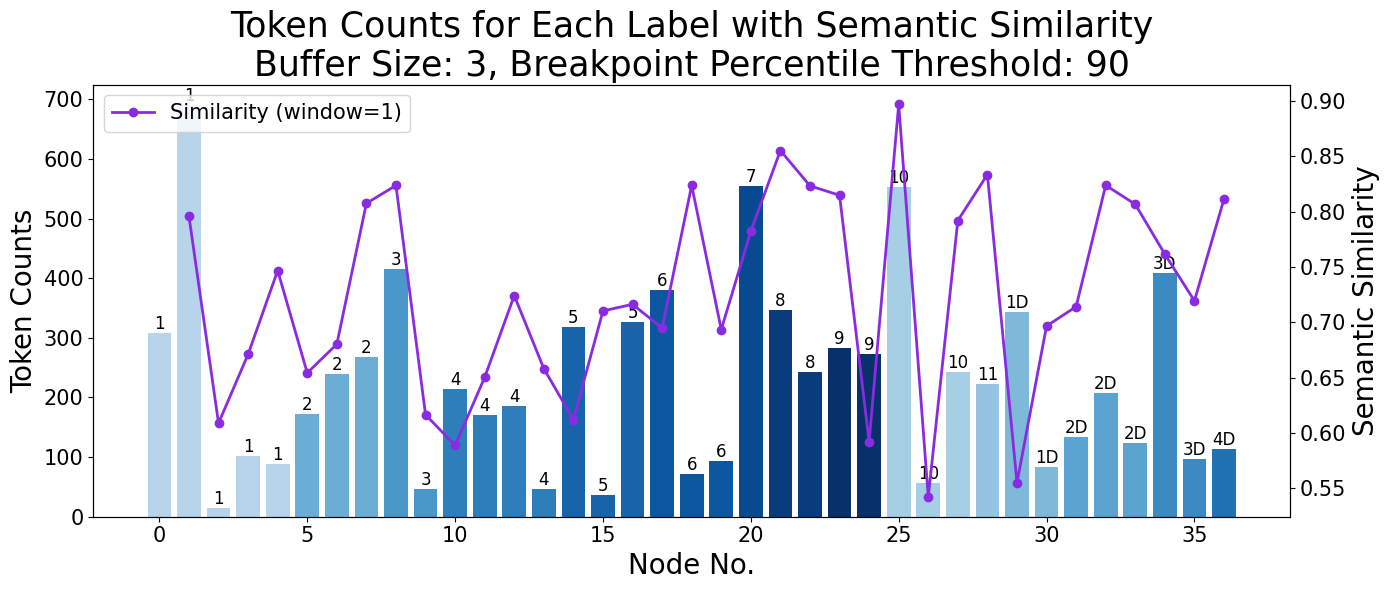

In [55]:
buffer_size = 3
breakpoint_percentile_threshold = 90

# Generate shades of blue for each unique page number
unique_pages = sorted(set(source_numbers))
page_colors = plt.get_cmap('Blues')  # Use the 'Blues' colormap
color_map = {page: page_colors(0.3 + 0.7 * i / (len(unique_pages) - 1)) for i, page in enumerate(unique_pages)}

# Get the list of colors for each bar based on the page number
bar_colors = [color_map[page] for page in source_numbers]

# Create the bar chart with a wider aspect ratio
fig, ax1 = plt.subplots(figsize=(14, 6))
bars = ax1.bar(range(len(token_counts)), token_counts, color=bar_colors)

# Add titles and labels for the first y-axis
title = f'Token Counts with Semantic Similarity\nBuffer Size: {buffer_size}, Breakpoint Percentile Threshold: {breakpoint_percentile_threshold}'
ax1.set_title(title, fontsize=25)
ax1.set_xlabel('Node No.', fontsize=20)
ax1.set_ylabel('Token Counts', fontsize=20)

# Add page number labels on each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{source_numbers[i]}', ha='center', va='bottom', color='black', fontsize=12)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Semantic Similarity', fontsize=20)

# Overlay semantic similarity as a line graph on the second y-axis
ax2.plot(range(1, len(token_counts)), similarity_scores, marker='o', color='blueviolet', label='Similarity (window=1)', linewidth=2)
#ax2.plot(range(1, len(token_counts)-1), similarity_scores_2, marker='s', color='crimson', label='Similarity (window=2)', linewidth=2)
#ax2.plot(range(1, len(token_counts)-2), similarity_scores_3, marker='^', color='yellowgreen', label='Similarity (window=3)', linewidth=2)

# Create a legend for the semantic similarity
ax2.legend(loc='upper left', fontsize=15)

# Set font sizes for x and y ticks
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


#### Split by character / token

